# Clean DMM data
It was found that the DMM data was needed before the calculation of the radiation damage.
For this we need to process and clean the DMM data.

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from io import StringIO

# Configuración de rutas (Input -> Output)
# Asegúrate de que las rutas relativas sean correctas desde donde ejecutas el notebook
config_rutas = {
    # Campaña 2 - Dry
    r'0_raw\Campaign2\cpld\dmm_dry': r'1_data\dmm_cpld_run2_dry.csv',
    
    # Campaña 2 - Run
    r'0_raw\Campaign2\cpld\dmm_run': r'1_data\dmm_cpld_run2.csv',
    
    # Campaña 3 - Run
    r'0_raw\Campaign3\cpld\dmm_run': r'1_data\dmm_cpld_run3.csv'
}

# Crear carpeta de destino si no existe
os.makedirs('1_data', exist_ok=True)

print("Configuración cargada. Rutas definidas:")
for k, v in config_rutas.items():
    print(f"Origen: {k} -> Destino: {v}")

Configuración cargada. Rutas definidas:
Origen: 0_raw\Campaign2\cpld\dmm_dry -> Destino: 1_data\dmm_cpld_run2_dry.csv
Origen: 0_raw\Campaign2\cpld\dmm_run -> Destino: 1_data\dmm_cpld_run2.csv
Origen: 0_raw\Campaign3\cpld\dmm_run -> Destino: 1_data\dmm_cpld_run3.csv


In [6]:
import pandas as pd
import numpy as np
import glob
import os
import re  # <--- Importante: Importamos Regex
from io import StringIO

def procesar_carpeta_dmm(input_folder):
    """
    Lee archivos, aplica limpieza profunda con Regex para eliminar 
    caracteres de control (basura binaria) y estandariza columnas.
    """
    files = glob.glob(os.path.join(input_folder, '*'))
    
    if not files:
        print(f" [!] No se encontraron archivos en {input_folder}")
        return None

    df_list = []
    
    print(f" -> Procesando {len(files)} archivos en: {input_folder}...")
    
    for file_path in files:
        try:
            with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
                content = f.read()
            
            # --- LIMPIEZA PROFUNDA ---
            # Usamos Regex para mantener SOLO:
            # - Caracteres imprimibles ASCII (rango hex 20 a 7E)
            # - Saltos de línea (\n, \r) y tabulaciones (\t)
            # Todo lo demás (incluido \x00, \x11, \x17, etc.) se borra.
            raw_text = re.sub(r'[^\x20-\x7E\n\r\t]', '', content)
            
            if not raw_text.strip():
                continue

            # Leer con pandas
            df_temp = pd.read_csv(
                StringIO(raw_text),
                delim_whitespace=True, 
                names=["ts", "IDC", "IAC"],
                comment="#",
                engine="python",
                on_bad_lines='skip'
            )
            
            # Conversión forzada a numérico (cualquier basura restante se vuelve NaN)
            df_temp['ts'] = pd.to_numeric(df_temp['ts'], errors='coerce')
            df_temp['IDC'] = pd.to_numeric(df_temp['IDC'], errors='coerce')
            
            # Limpieza lógica
            df_temp = df_temp.dropna(subset=['ts', 'IDC'])
            
            df_list.append(df_temp)
            
        except Exception as e:
            # Solo mostrar errores graves, ignorar archivos que no son texto
            pass

    if df_list:
        full_df = pd.concat(df_list, ignore_index=True)
        
        # Procesar Timestamp
        full_df["time"] = pd.to_datetime(full_df["ts"], unit="s")
        full_df["time"] = full_df["time"] + pd.Timedelta(hours=2)
        full_df = full_df.set_index("time").sort_index()
        
        # Eliminar duplicados
        full_df = full_df[~full_df.index.duplicated(keep='first')]
        
        full_df = full_df.drop(columns=['ts'])
        return full_df
    else:
        return None

In [7]:
# Ejecución del pipeline
for input_dir, output_file in config_rutas.items():
    print(f"\nIniciando tarea: {input_dir}")
    
    df_clean = procesar_carpeta_dmm(input_dir)
    
    if df_clean is not None and not df_clean.empty:
        # Guardar a CSV
        df_clean.to_csv(output_file)
        
        print(f" [OK] Guardado exitosamente: {output_file}")
        print(f"      Dimensiones: {df_clean.shape}")
        print(f"      Rango temporal: {df_clean.index.min()} a {df_clean.index.max()}")
        print(f"      Columnas detectadas: {df_clean.columns.tolist()}")
    else:
        print(" [!] No se generaron datos para esta ruta.")


Iniciando tarea: 0_raw\Campaign2\cpld\dmm_dry
 -> Procesando 36 archivos en: 0_raw\Campaign2\cpld\dmm_dry...
 [OK] Guardado exitosamente: 1_data\dmm_cpld_run2_dry.csv
      Dimensiones: (9451, 2)
      Rango temporal: 2022-09-13 23:12:42.316342016 a 2022-09-14 11:34:28.871010304
      Columnas detectadas: ['IDC', 'IAC']

Iniciando tarea: 0_raw\Campaign2\cpld\dmm_run
 -> Procesando 1 archivos en: 0_raw\Campaign2\cpld\dmm_run...
 [OK] Guardado exitosamente: 1_data\dmm_cpld_run2.csv
      Dimensiones: (259109, 2)
      Rango temporal: 2022-09-14 11:36:05.253848320 a 2022-09-21 10:40:41.657151744
      Columnas detectadas: ['IDC', 'IAC']

Iniciando tarea: 0_raw\Campaign3\cpld\dmm_run
 -> Procesando 868 archivos en: 0_raw\Campaign3\cpld\dmm_run...
 [OK] Guardado exitosamente: 1_data\dmm_cpld_run3.csv
      Dimensiones: (269698, 2)
      Rango temporal: 2022-11-09 11:52:35.385599232 a 2022-11-16 10:49:25.645891072
      Columnas detectadas: ['IDC', 'IAC']


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def test_current_files(files_to_test):
    for test_file in files_to_test:
        print(f"\n{'='*80}")
        print(f">>> ANALIZANDO: {os.path.basename(test_file)}")
        
        if os.path.exists(test_file):
            try:
                # Cargar datos
                df_verif = pd.read_csv(test_file, index_col='time', parse_dates=True)
                
                if df_verif.empty:
                    print(" [ALERTA] El archivo existe pero está vacío.")
                    continue

                # 1. Graficar
                plt.figure(figsize=(15, 4))
                
                # Graficar IDC (Corriente Principal)
                plt.plot(df_verif.index, df_verif['IDC'], label='IDC (DC)', linewidth=0.5, color='#1f77b4')
                
                # Graficar IAC solo si tiene datos válidos (evita errores en gráficos vacíos)
                has_iac = 'IAC' in df_verif.columns and df_verif['IAC'].notna().sum() > 0
                if has_iac:
                    plt.plot(df_verif.index, df_verif['IAC'], label='IAC (AC)', linewidth=0.5, alpha=0.6, color='#ff7f0e')
                    
                plt.title(f"Perfil de Corriente: {os.path.basename(test_file)}")
                plt.ylabel("Corriente (A)")
                plt.xlabel("Tiempo (UTC)")
                plt.legend(loc='upper right')
                plt.grid(True, which='both', linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()
                
                # 2. Reporte de Estadísticas
                print(f" -> Dimensiones del Dataset: {df_verif.shape}")
                print(f" -> Inicio: {df_verif.index.min()}")
                print(f" -> Fin:    {df_verif.index.max()}")
                print(f" -> Duración Aprox: {df_verif.index.max() - df_verif.index.min()}")
                
                # Estadísticas rápidas de corriente para detectar anomalías (ej. ceros o infinitos)
                mean_idc = df_verif['IDC'].mean()
                max_idc = df_verif['IDC'].max()
                print(f" -> IDC (Media): {mean_idc:.4e} A | IDC (Max): {max_idc:.4e} A")
                
                if not has_iac:
                    print(" -> Nota: No se detectaron datos de IAC (Corriente AC) en este archivo.")
                
                print(" -> Muestra de las primeras filas:")
                print(df_verif.head(3))
                
            except Exception as e:
                print(f" [ERROR] Falló la lectura o graficado: {e}")
        else:
            print(f" [!] Archivo NO encontrado: {test_file}")
            print("     Verifica que ejecutaste la celda de procesamiento anterior.")

In [ ]:
# Lista de archivos que definimos en la configuración anterior
files_to_test = [
    r'1_data\dmm_cpld_run2_dry.csv',
    r'1_data\dmm_cpld_run2.csv',
    r'1_data\dmm_cpld_run3.csv'
]

test_current_files(files_to_test)

## Analysis of the data

In [ ]:
df_run2 = pd.read_csv(r'1_data\dmm_cpld_run2.csv', index_col='time', parse_dates=True)
df_run3 = pd.read_csv(r'1_data\dmm_cpld_run3.csv', index_col='time', parse_dates=True)

=== Análisis de Tiempo: Campaign 2 (Run) ===
 -> Paso Medio (Mean dt):   2.321335 s
 -> Mediana (Median dt):    2.066167 s
 -> Desviación Std (Jitter):42.357999 s
 -> Rango [Min, Max]:       [1.543, 21539.855] s
 -> Forma: Skewness=507.38, Kurtosis=257969.71


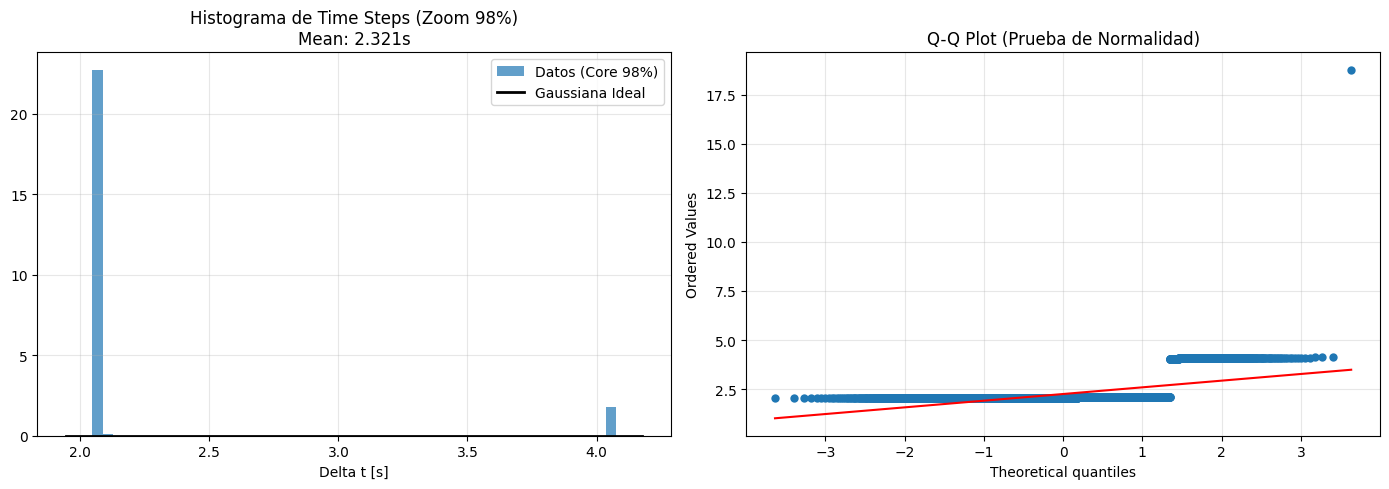

=== Análisis de Tiempo: Campaign 3 (Run) ===
 -> Paso Medio (Mean dt):   2.228465 s
 -> Mediana (Median dt):    2.264188 s
 -> Desviación Std (Jitter):1.661289 s
 -> Rango [Min, Max]:       [2.139, 535.917] s
 -> Forma: Skewness=264.02, Kurtosis=73021.25


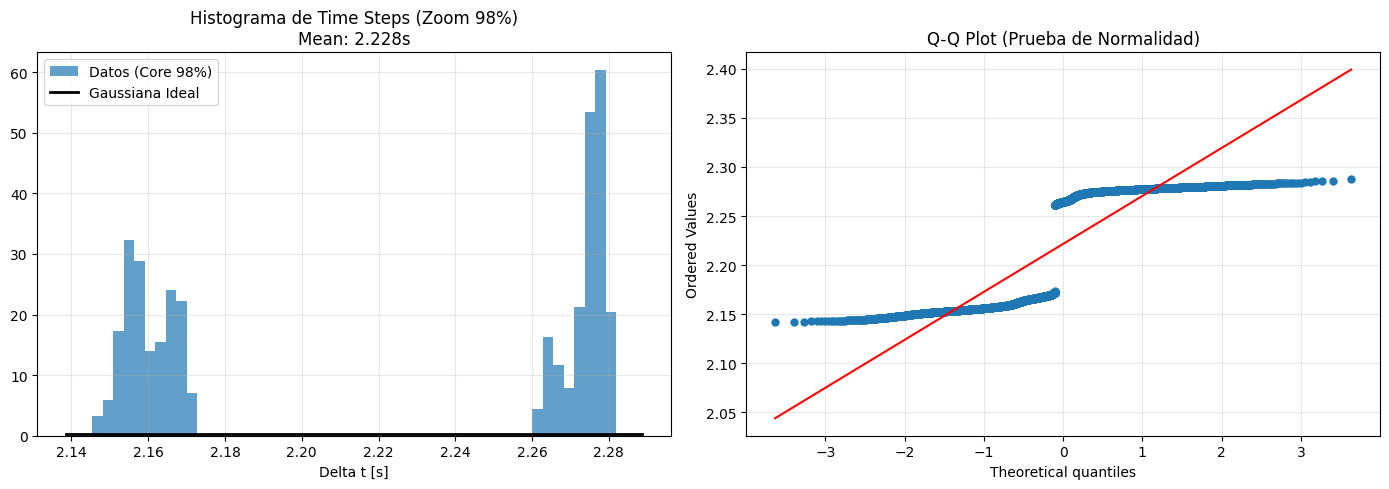

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def analyze_time_distribution(df, dataset_name="Dataset"):
    """
    Calcula el time-step (dt), sus estadísticas y verifica Gaussianidad.
    """
    # 1. Calcular Delta t (diferencia entre índices consecutivos)
    # Asumimos que el índice es datetime64[ns]
    dt_series = df.index.to_series().diff().dt.total_seconds().dropna()
    
    # 2. Estadísticas Clave
    mean_dt = dt_series.mean()
    median_dt = dt_series.median()
    std_dt = dt_series.std()
    min_dt = dt_series.min()
    max_dt = dt_series.max()
    
    # Kurtosis y Skewness (Para prueba numérica de normalidad)
    # Skewness ~ 0 es simétrico. Kurtosis ~ 3 (o 0 según definición de Fisher) es Normal.
    kurt = dt_series.kurtosis()
    skew = dt_series.skew()

    print(f"=== Análisis de Tiempo: {dataset_name} ===")
    print(f" -> Paso Medio (Mean dt):   {mean_dt:.6f} s")
    print(f" -> Mediana (Median dt):    {median_dt:.6f} s")
    print(f" -> Desviación Std (Jitter):{std_dt:.6f} s")
    print(f" -> Rango [Min, Max]:       [{min_dt:.3f}, {max_dt:.3f}] s")
    print(f" -> Forma: Skewness={skew:.2f}, Kurtosis={kurt:.2f}")
    
    # Interpretación rápida automática
    if abs(mean_dt - median_dt) > std_dt:
        print(" [!] ALERTA: Distribución sesgada (Media lejos de Mediana). Posibles Gaps.")
    
    # 3. Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histograma
    # Usamos un rango restringido (percentil 1 a 99) para ignorar gaps gigantes y ver el jitter
    p01, p99 = np.percentile(dt_series, [1, 99])
    dt_filtered = dt_series[(dt_series >= p01) & (dt_series <= p99)]
    
    axes[0].hist(dt_filtered, bins=50, color='#1f77b4', alpha=0.7, density=True, label='Datos (Core 98%)')
    
    # Superponer curva Gaussiana ideal
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean_dt, std_dt)
    axes[0].plot(x, p, 'k', linewidth=2, label='Gaussiana Ideal')
    axes[0].set_title(f"Histograma de Time Steps (Zoom 98%)\nMean: {mean_dt:.3f}s")
    axes[0].set_xlabel("Delta t [s]")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Q-Q Plot
    # Usamos una muestra aleatoria si son demasiados datos para no saturar el plot
    if len(dt_series) > 5000:
        sample_dt = dt_series.sample(5000)
    else:
        sample_dt = dt_series
        
    stats.probplot(sample_dt, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot (Prueba de Normalidad)")
    axes[1].get_lines()[0].set_markerfacecolor('#1f77b4')
    axes[1].get_lines()[0].set_markeredgewidth(0)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return dt_series

# Ejecutar análisis
dt_run2_dt = analyze_time_distribution(df_run2, "Campaign 2 (Run)")
dt_run3_dt = analyze_time_distribution(df_run3, "Campaign 3 (Run)")

# Data cleaning and error asignation
As some data present the clearly the peaks of SEF its convenient to mark it at this point in order to have the data fully derived.

## Dry run cleanage
As it is observed there's something weird about the last part of run2, we are going to assume some external effect

--- Estadísticas de Referencia (Primera Mitad) ---
 Media (Baseline): 0.062897 A
 Std Dev (Sigma):  0.000223 A
 Umbral Sup (+5s): 0.064010 A
 Umbral Inf (-5s): 0.061784 A

--- Resultado de Limpieza ---
 Puntos totales: 9451
 Puntos removidos: 531 (5.62%)


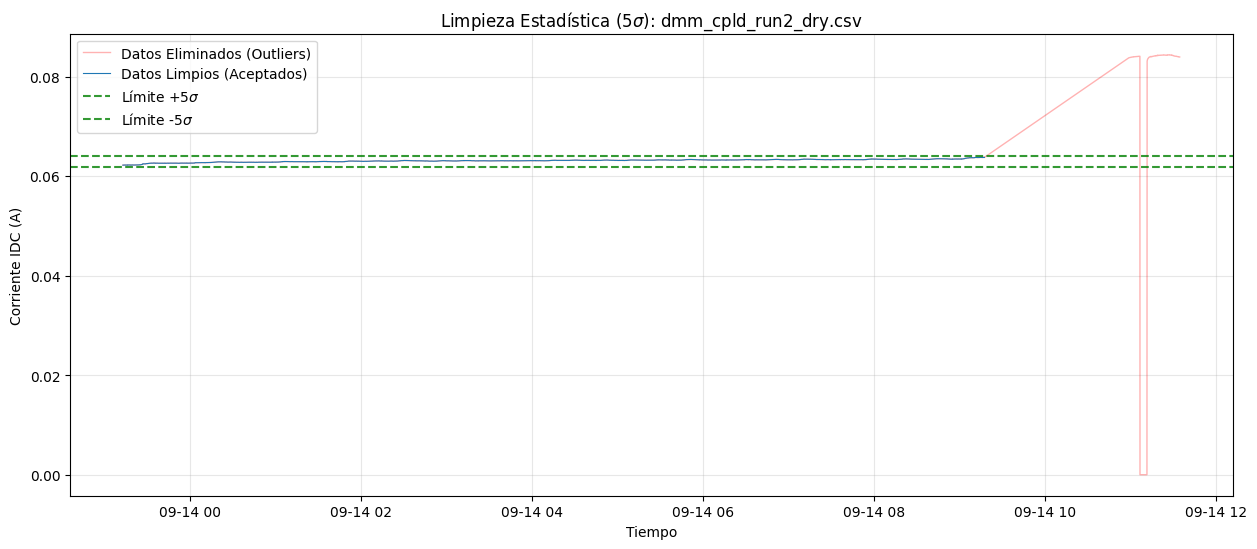

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración del archivo
file_path = r'1_data\dmm_cpld_run2_dry.csv'

def clean_by_stable_reference(file_path, sigma_threshold=5):
    """
    Limpia el perfil de corriente usando la primera mitad de los datos 
    como referencia estadística (Baseline).
    """
    # 1. Cargar datos
    if not os.path.exists(file_path):
        print(f" [!] Archivo no encontrado: {file_path}")
        return None
    
    df = pd.read_csv(file_path, index_col='time', parse_dates=True)
    
    # 2. Definir la zona de referencia (Primera mitad)
    midpoint_idx = len(df) // 2
    reference_slice = df.iloc[:midpoint_idx]
    
    # 3. Calcular Estadísticas Robustas sobre la referencia
    baseline_mean = reference_slice['IDC'].mean()
    baseline_std = reference_slice['IDC'].std()
    
    # 4. Definir Umbrales (Criterio de N-Sigmas)
    upper_limit = baseline_mean + (sigma_threshold * baseline_std)
    lower_limit = baseline_mean - (sigma_threshold * baseline_std)
    
    print(f"--- Estadísticas de Referencia (Primera Mitad) ---")
    print(f" Media (Baseline): {baseline_mean:.6f} A")
    print(f" Std Dev (Sigma):  {baseline_std:.6f} A")
    print(f" Umbral Sup (+{sigma_threshold}s): {upper_limit:.6f} A")
    print(f" Umbral Inf (-{sigma_threshold}s): {lower_limit:.6f} A")
    
    # 5. Aplicar Filtro a TODO el dataset
    # Identificamos outliers
    mask_good = (df['IDC'] >= lower_limit) & (df['IDC'] <= upper_limit)
    df_clean = df[mask_good].copy()
    n_removed = len(df) - len(df_clean)
    
    print(f"\n--- Resultado de Limpieza ---")
    print(f" Puntos totales: {len(df)}")
    print(f" Puntos removidos: {n_removed} ({n_removed/len(df)*100:.2f}%)")
    
    # 6. Visualización Comparativa
    plt.figure(figsize=(15, 6))
    
    # Graficar datos originales (en gris/rojo para destacar lo eliminado)
    plt.plot(df.index, df['IDC'], color='red', alpha=0.3, label='Datos Eliminados (Outliers)', linewidth=1)
    
    # Graficar datos limpios (en azul)
    plt.plot(df_clean.index, df_clean['IDC'], color='#1f77b4', label='Datos Limpios (Aceptados)', linewidth=0.8)
    
    # Dibujar las líneas de umbral
    plt.axhline(y=upper_limit, color='green', linestyle='--', alpha=0.8, label=f'Límite +{sigma_threshold}$\sigma$')
    plt.axhline(y=lower_limit, color='green', linestyle='--', alpha=0.8, label=f'Límite -{sigma_threshold}$\sigma$')
    
    plt.title(f"Limpieza Estadística ({sigma_threshold}$\sigma$): {os.path.basename(file_path)}")
    plt.ylabel("Corriente IDC (A)")
    plt.xlabel("Tiempo")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return df_clean

# Ejecutar limpieza
df_run2_dry_clean = clean_by_stable_reference(file_path, sigma_threshold=5)

# Opcional: Sobrescribir el archivo limpio si el resultado es satisfactorio
df_run2_dry_clean.to_csv(file_path)

## Run data

Sin embargo esta corriente no es correcta, no es el modo de funcionamiento

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_latchups(df_in, current_col, off_th, idle_low, idle_high, stability_window=3):
    """
    Detecta eventos de Latch-up y Recuperación, enriqueciendo el DataFrame original.
    
    Reglas:
    1. Inicio: Transición de estado IDLE (previo) a OFF (actual).
    2. Fin: El valor regresa al rango IDLE y se mantiene por 'stability_window' muestras.
    
    Args:
        df_in (pd.DataFrame): DataFrame con índice datetime.
        current_col (str): Nombre de la columna de corriente.
        off_th (float): Umbral máximo para considerar estado OFF/LATCH-UP.
        idle_low (float): Límite inferior del estado IDLE.
        idle_high (float): Límite superior del estado IDLE.
        stability_window (int): Muestras consecutivas requeridas para confirmar recuperación.
        
    Returns:
        df_out (pd.DataFrame): Copia del DF original con columnas 'off_detected' y 'latch_up'.
        events_df (pd.DataFrame): Resumen de eventos (inicio, fin, duración).
    """
    # Trabajamos sobre una copia para no alterar el original inadvertidamente
    df = df_in.copy().sort_index()
    
    # Inicializar columnas nuevas
    df['off_detected'] = False # True solo en el instante del drop
    df['latch_up'] = False     # True durante toda la duración del evento
    
    # Extraer arrays numpy para velocidad
    idc = df[current_col].values
    times = df.index
    n = len(idc)
    
    events_list = []
    
    # Variables de estado
    in_latchup = False
    start_idx = 0
    
    # Iteramos sobre el array (desde el segundo elemento)
    # Usamos un while para poder saltar índices si confirmamos recuperación
    i = 1
    while i < n:
        curr_val = idc[i]
        prev_val = idc[i-1]
        
        # --- LÓGICA DE DETECCIÓN DE INICIO ---
        if not in_latchup:
            # Condición: Estaba en IDLE y cayó a OFF
            prev_is_idle = (prev_val >= idle_low) and (prev_val <= idle_high)
            curr_is_off = (curr_val < off_th)
            
            if prev_is_idle and curr_is_off:
                in_latchup = True
                start_idx = i
                df.iloc[i, df.columns.get_loc('off_detected')] = True
        
        # --- LÓGICA DE DETECCIÓN DE RECUPERACIÓN ---
        else: # Estamos dentro de un latchup
            # Verificamos si entramos en zona de recuperación potencial
            if (curr_val >= idle_low) and (curr_val <= idle_high):
                # Mirar adelante para confirmar estabilidad (Look-ahead)
                # Verificamos si los siguientes (stability_window - 1) puntos también son estables
                is_stable = True
                if i + stability_window <= n:
                    window = idc[i : i + stability_window]
                    if not np.all((window >= idle_low) & (window <= idle_high)):
                        is_stable = False
                else:
                    # Si no quedan suficientes datos, no podemos confirmar estabilidad
                    is_stable = False
                
                if is_stable:
                    # ¡Recuperación Confirmada!
                    end_idx = i # El fin del latchup es justo antes de empezar a ser estable
                    
                    # Marcar el rango en la columna latch_up
                    # Desde start_idx hasta end_idx (sin incluir el punto de recuperación estable)
                    df.iloc[start_idx : end_idx, df.columns.get_loc('latch_up')] = True
                    
                    # Guardar evento
                    events_list.append({
                        'start_time': times[start_idx],
                        'end_time': times[end_idx],
                        'duration_s': (times[end_idx] - times[start_idx]).total_seconds(),
                        'min_current': np.min(idc[start_idx : end_idx]),
                        'recovery_current': curr_val
                    })
                    
                    in_latchup = False
                    # Avanzamos el índice para no re-evaluar los puntos de estabilidad
                    i += (stability_window - 1)
            
        i += 1
        
    # Manejo de caso borde: Latch-up activo al final del archivo
    if in_latchup:
        df.iloc[start_idx:, df.columns.get_loc('latch_up')] = True
        events_list.append({
            'start_time': times[start_idx],
            'end_time': times[-1],
            'duration_s': (times[-1] - times[start_idx]).total_seconds(),
            'min_current': np.min(idc[start_idx:]),
            'recovery_current': None # No recuperado
        })

    events_df = pd.DataFrame(events_list)
    if not events_df.empty:
        events_df = events_df.set_index('start_time')
        
    return df, events_df

def plot_latchup_analysis(df, events_df, current_col='IDC', title_campaign="Campaign X"):
    """
    Grafica la serie de tiempo usando las columnas booleanas generadas.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 1. Graficar corriente completa
    ax.plot(df.index, df[current_col], label='Monitor Current', color='#1f77b4', linewidth=0.8, alpha=0.8)
    
    # 2. Graficar zonas de Latch-up (Donde la columna latch_up es True)
    # Usamos fill_between condicional
    # Creamos una serie numérica para fill_between: min_val y max_val del plot
    y_min, y_max = df[current_col].min(), df[current_col].max()
    margin = (y_max - y_min) * 0.1
    
    ax.fill_between(df.index, y_min - margin, y_max + margin, 
                    where=df['latch_up'], 
                    color='red', alpha=0.15, label='Active Latch-up Region')

    # 3. Marcar puntos de Detección (Donde off_detected es True)
    off_points = df[df['off_detected']]
    if not off_points.empty:
        ax.scatter(off_points.index, off_points[current_col], 
                   color='red', marker='x', s=50, zorder=5, label='Detected OFF Trigger')

    # 4. Marcar puntos de Recuperación (Basado en el events_df)
    if not events_df.empty:
        # Filtramos los que tienen recuperación (recovery_current no es None)
        recovered = events_df.dropna(subset=['recovery_current'])
        if not recovered.empty:
            ax.scatter(recovered['end_time'], recovered['recovery_current'], 
                       color='green', marker='o', s=40, zorder=5, label='Stable Recovery')

    ax.set_title(f"{title_campaign} Latch-up Detection: {len(events_df)} events found")
    ax.set_ylabel("Current [A]")
    ax.set_xlabel("Time")
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()



In [32]:
# umbrales obtenidos de la limpieza anterior
OFF_TH = 0.02 # definido de ver las estadisticas, pero posible cambiarlo
IDLE_HIGH = 0.095
IDLE_LOW = 0.08

Campaña 2: Eventos detectados: 182


,end_time,duration_s,min_current,recovery_current
start_time,,,,
2022-09-14 20:53:19.447939584,2022-09-14 20:54:20.527870464,61.079930,5.527897e-07,0.082445
2022-09-15 11:06:58.954968320,2022-09-15 11:08:08.030469888,69.075501,8.046380e-07,0.082713
2022-09-15 11:08:56.828372480,2022-09-15 11:13:27.499885568,270.671513,4.911499e-07,0.082202
2022-09-15 11:33:32.715351040,2022-09-15 11:38:32.825378304,300.110027,2.651265e-08,0.082220
2022-09-15 12:49:20.230484992,2022-09-15 12:54:20.043520768,299.813035,2.096581e-08,0.082099


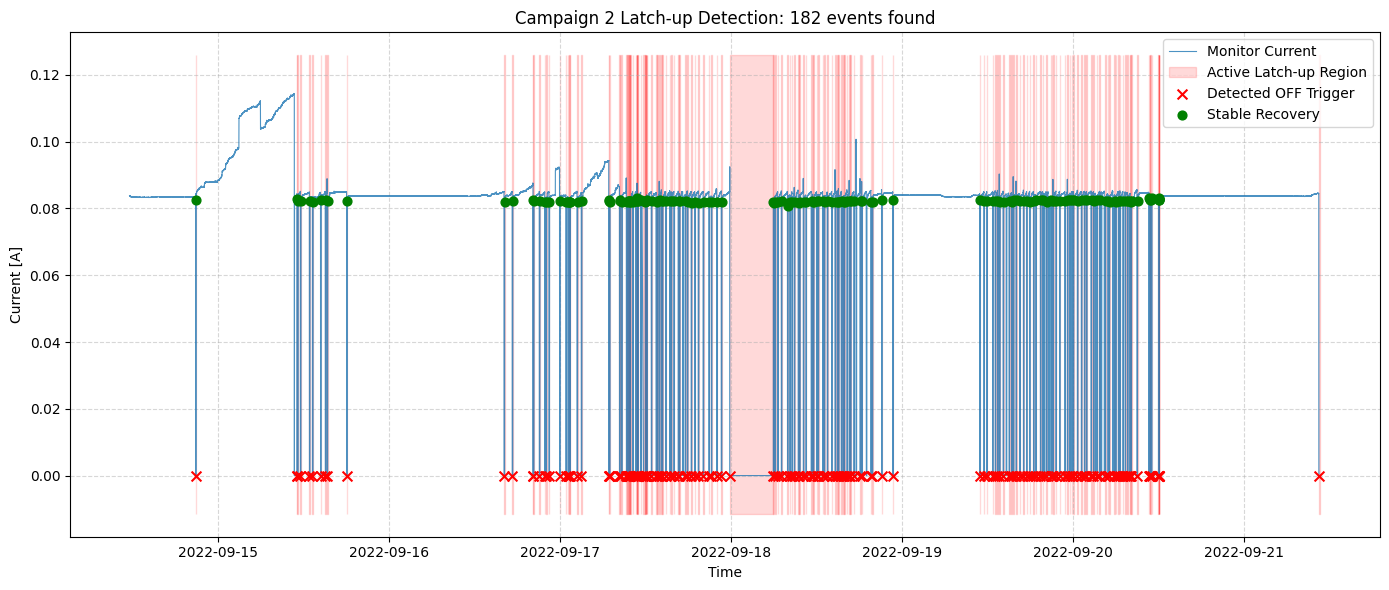

In [51]:

# Ejemplo hipotético de uso:
df_processed_2, df_events_2 = process_latchups(
    df_run2, 
    current_col='IDC', 
    off_th=OFF_TH,          # Ejemplo: debajo de 40mA es OFF
    idle_low=IDLE_LOW,       # Ejemplo: 80mA minimo idle
    idle_high=IDLE_HIGH,      # Ejemplo: 85mA maximo idle
    stability_window=3    # Sean 3 puntos estables para confirmar recuperación
)

print(f"Campaña 2: Eventos detectados: {len(df_events_2)}")
display(df_events_2.head())

plot_latchup_analysis(df_processed_2, df_events_2, current_col='IDC', title_campaign="Campaign 2")

Eventos detectados: 177


,end_time,duration_s,min_current,recovery_current
start_time,,,,
2022-11-09 15:28:33.388674560,2022-11-09 15:34:19.702382336,346.313707,0.000070,0.080022
2022-11-09 16:51:05.244915200,2022-11-09 16:51:20.470349312,15.225434,0.000080,0.080100
2022-11-09 19:07:36.945584128,2022-11-09 19:07:47.846365952,10.900781,0.000084,0.080117
2022-11-09 21:53:49.834390784,2022-11-09 21:59:51.009662720,361.175271,0.000067,0.080006
2022-11-10 09:38:47.607470592,2022-11-10 09:44:36.693836288,349.086365,0.000075,0.080067


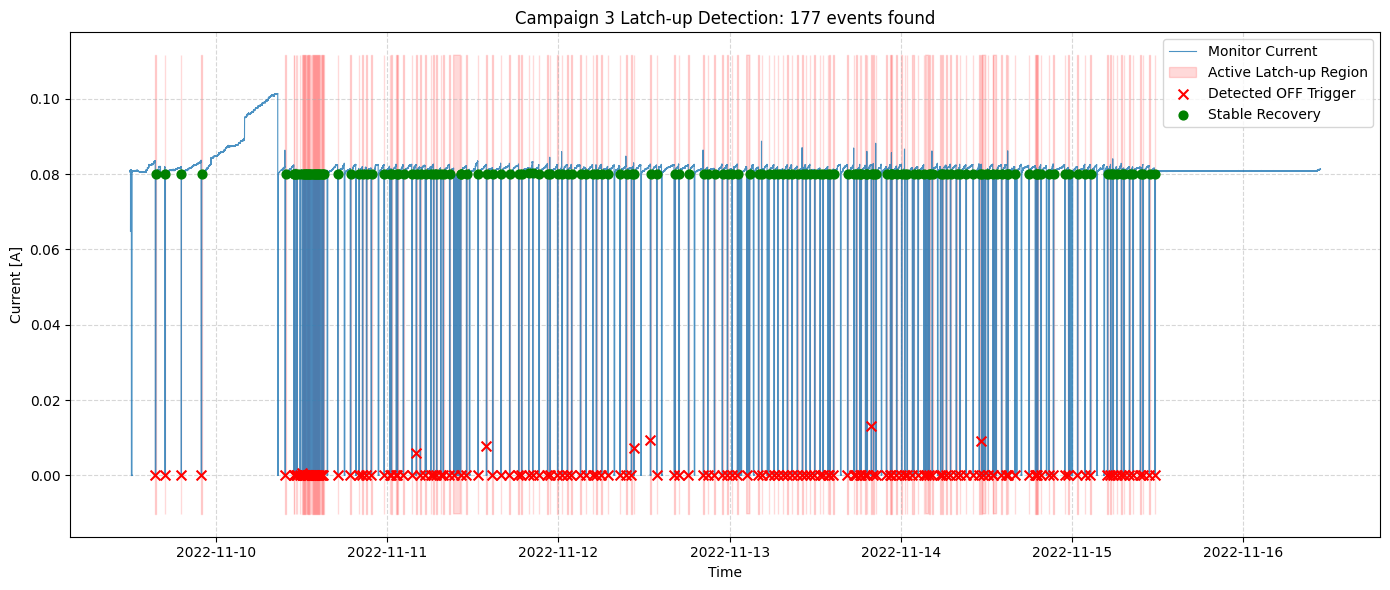

In [52]:
# Ejemplo hipotético de uso:
df_processed_3, df_events_3 = process_latchups(
    df_run3, 
    current_col='IDC', 
    off_th=OFF_TH,          # Ejemplo: debajo de 40mA es OFF
    idle_low=IDLE_LOW,       # Ejemplo: 80mA minimo idle
    idle_high=IDLE_HIGH,      # Ejemplo: 85mA maximo idle
    stability_window=3    # Sean 3 puntos estables para confirmar recuperación
)

print(f"Eventos detectados: {len(df_events_3)}")
display(df_events_3.head())

plot_latchup_analysis(df_processed_3, df_events_3, current_col='IDC', title_campaign="Campaign 3")

--- Estadísticas Run 2 ---
min         6.202139
50%       301.213026
max     22052.253971
mean      382.938326
Name: duration_s, dtype: float64

--- Estadísticas Run 3 ---
min        8.753758
50%      328.226823
max     3497.287361
mean     376.061725
Name: duration_s, dtype: float64


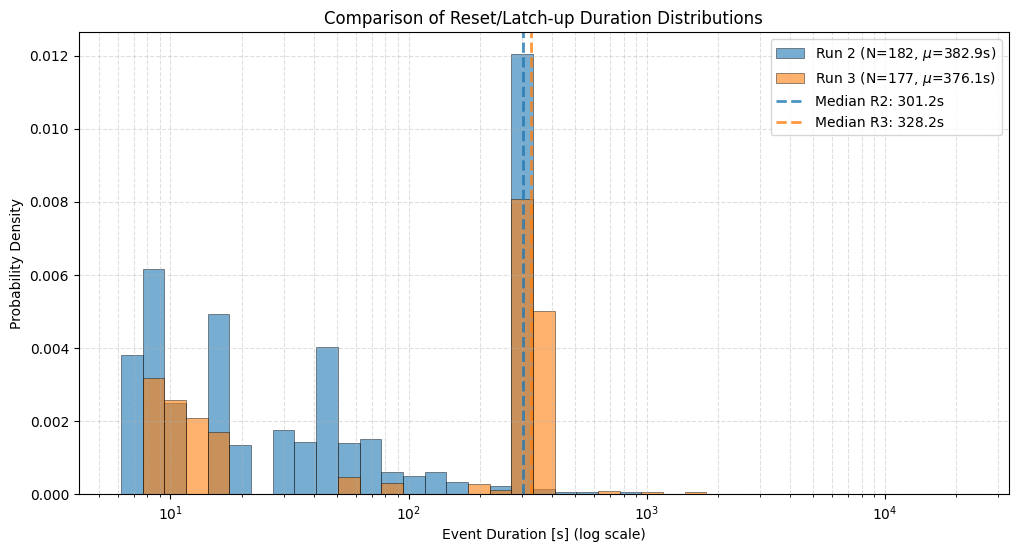

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_duration_distribution(df2, df3, bins=50, log_scale=True):
    """
    Plotea la distribución comparativa de duraciones de Latch-up.
    
    Args:
        df2, df3: DataFrames de eventos (deben tener columna 'duration_s')
        bins: Número de bins
        log_scale: Si True, usa bins logarítmicos (útil para rangos amplios)
    """
    # 1. Extraer datos y limpiar nulos
    d2 = df2['duration_s'].dropna()
    d3 = df3['duration_s'].dropna()
    
    # 2. Definir Bins Comunes
    # Encontramos el min y max global para que los bins cubran todo el rango
    global_min = min(d2.min(), d3.min())
    global_max = max(d2.max(), d3.max())
    
    if log_scale:
        # Bins espaciados logarítmicamente (mejor para ver 1s vs 1000s)
        # Evitamos log(0) asegurando que el min sea > 0
        safe_min = max(global_min, 0.1) 
        bins_edges = np.logspace(np.log10(safe_min), np.log10(global_max), bins)
    else:
        # Bins lineales estándar
        bins_edges = np.linspace(global_min, global_max, bins)

    # 3. Configurar Plot
    plt.figure(figsize=(12, 6))
    
    # Histograma Run 2
    plt.hist(d2, bins=bins_edges, density=True, 
             alpha=0.6, color='#1f77b4', edgecolor='black', linewidth=0.5,
             label=f'Run 2 (N={len(d2)}, $\mu$={d2.mean():.1f}s)')
    
    # Histograma Run 3
    plt.hist(d3, bins=bins_edges, density=True, 
             alpha=0.6, color='#ff7f0e', edgecolor='black', linewidth=0.5,
             label=f'Run 3 (N={len(d3)}, $\mu$={d3.mean():.1f}s)')

    # 4. Añadir líneas de Mediana (Más robusto que la media en duraciones)
    plt.axvline(d2.median(), color='#1f77b4', linestyle='--', linewidth=2, alpha=0.8, label=f'Median R2: {d2.median():.1f}s')
    plt.axvline(d3.median(), color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8, label=f'Median R3: {d3.median():.1f}s')

    # 5. Estética
    if log_scale:
        plt.xscale('log')
        plt.xlabel('Event Duration [s] (log scale)')
    else:
        plt.xlabel('Event Duration [s]')
        
    plt.ylabel('Probability Density')
    plt.title('Comparison of Reset/Latch-up Duration Distributions')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.4)
    
    # Mostrar estadísticas básicas en consola
    print(f"--- Estadísticas Run 2 ---")
    print(d2.describe()[['min', '50%', 'max', 'mean']])
    print(f"\n--- Estadísticas Run 3 ---")
    print(d3.describe()[['min', '50%', 'max', 'mean']])
    
    plt.show()

# Ejecutar
# Prueba primero con log_scale=True si tienes duraciones muy dispares (ej. 2s y 300s)
plot_duration_distribution(df_events_2, df_events_3, bins=40, log_scale=True)


In [47]:
df_events_2 = df_events_2[df_events_2['duration_s'] > 0]
df_events_3 = df_events_3[df_events_3['duration_s'] > 0]
df_events_2.to_csv("./1_data/df_latchup_2.csv")
df_events_3.to_csv("./1_data/df_latchup_3.csv")

df_processed_2.to_csv("./1_data/dmm_cpld_run2.csv")
df_processed_3.to_csv("./1_data/dmm_cpld_run3.csv")